<a href="https://colab.research.google.com/github/Deleon57/EDAR-REGRESSION/blob/main/Pipeline_1_(GFI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import shap

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Regressor models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Setup
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


#Helpers

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# --- Error Metrics ---
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denom != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100

def metrics_dict(y_true, y_pred) -> Dict[str, float]:
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE%": mape(y_true, y_pred),
        "SMAPE%": smape(y_true, y_pred),
        "R²": r2_score(y_true, y_pred),
    }

# --- Plot Helpers ---
def plot_series(df, date_col, value_col, title="Series"):
    plt.figure(figsize=(12, 4))
    plt.plot(df[date_col], df[value_col])
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(value_col)
    plt.tight_layout()
    plt.show()

def add_time_idx(df, date_col="Date"):
    df = df.copy()
    df["t"] = (pd.to_datetime(df[date_col]) - pd.to_datetime(df[date_col]).min()).dt.days
    return df

# --- Technical Indicators ---
def rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.rolling(window).mean()
    ma_down = down.rolling(window).mean()
    rs = ma_up / (ma_down + 1e-12)
    return 100 - (100 / (1 + rs))

def macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    hist = macd_line - signal_line
    return macd_line, signal_line, hist


#Load Data

📥 Fetching GFI data from Yahoo Finance...


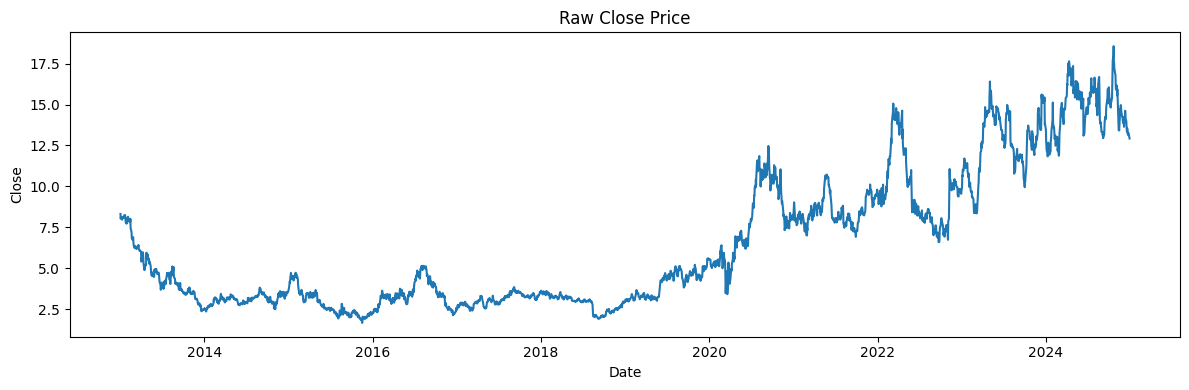

Price,Date,Close,High,Low,Open,Volume
Ticker,,GFI,GFI,GFI,GFI,GFI
0,2013-01-02,8.313619,8.426956,8.260284,8.373621,4370817
1,2013-01-03,8.020275,8.373620,7.993607,8.260283,5623304
2,2013-01-04,8.140279,8.146945,7.933605,8.006941,2907492
3,2013-01-07,8.026944,8.173616,8.006944,8.053612,4885720
4,2013-01-08,8.000276,8.033611,7.913606,8.000276,3984784


In [ ]:
import pandas as pd
import yfinance as yf

# Fetch data directly from Yahoo Finance (2013–2024)
TICKER, START, END = "GFI", "2013-01-01", "2024-12-31"  #Change the dates here
print(f"📥 Fetching {TICKER} data from Yahoo Finance...")

df = yf.download(TICKER, start=START, end=END, progress=False).reset_index()

# Final cleaning
df = df.dropna().reset_index(drop=True)

# Plot Close price series
plot_series(df, "Date", "Close", "Raw Close Price")

# Preview
df.head()


# Feature Engineering

In [ ]:
import pandas as pd
import numpy as np

work = df.copy()

# --- Basic Features ---
work["Return"] = np.log(work["Close"]).diff()
for lag in [1, 5, 10]:
    work[f"Lag{lag}"] = work["Close"].shift(lag)

# --- Rolling Window Features ---
for w in [5, 10, 20, 60]:
    work[f"RollMean_{w}"] = work["Close"].rolling(w).mean()
    work[f"RollStd_{w}"] = work["Close"].rolling(w).std()

# --- Technical Indicators ---
work["RSI_14"] = rsi(work["Close"], 14)
macd_line, sig, hist = macd(work["Close"], 12, 26, 9)
work["MACD"], work["MACDsig"], work["MACDh"] = macd_line, sig, hist

# --- Date-based Features ---
work["Year"] = work["Date"].dt.year
work["Month"] = work["Date"].dt.month
work["Day"] = work["Date"].dt.day
work = add_time_idx(work, "Date")

# --- Target: next-day close ---
work["y"] = work["Close"].shift(-1)

# --- Drop NaNs (from lags/rolls/target) ---
work = work.dropna().reset_index(drop=True)

# --- Strict Numeric Features Only ---
candidates = work.drop(columns=["Date", "y"], errors="ignore")
numeric_only = candidates.select_dtypes(include=[np.number]).copy()
non_numeric = sorted(set(candidates.columns) - set(numeric_only.columns))
if non_numeric:
    print("Dropping non-numeric columns:", non_numeric)

# --- Ensure valid numeric data ---
X = numeric_only.apply(pd.to_numeric, errors="coerce").astype("float64")
y = pd.to_numeric(work["y"], errors="coerce").astype("float64").values

# --- Filter valid rows ---
valid = np.isfinite(X).all(axis=1) & np.isfinite(y)
if valid.sum() < len(y):
    print(f"Filtered out {len(y) - valid.sum()} rows with non-finite values")

# Keep only valid rows
work = work.loc[valid].reset_index(drop=True)
X = X.loc[valid].reset_index(drop=True)
y = y[valid]
feat_cols = X.columns.tolist()

# --- Final Sanity Check ---
assert all(pd.api.types.is_numeric_dtype(X[c]) for c in X.columns), "Non-numeric features found!"
print(f"✅ Feature matrix shape: {X.shape}; Target shape: {y.shape}")


✅ Feature matrix shape: (2959, 25); Target shape: (2959,)


# Test/Train Split  

In [ ]:
import numpy as np
import pandas as pd

# Define cutoff date (train before, test after)
CUTOFF_DATE = pd.Timestamp("2023-01-01")
mask_train = work["Date"] < CUTOFF_DATE

# Split features (X) and target (y)
X_train = X.loc[mask_train].values
y_train = work.loc[mask_train, "y"].values

X_test = X.loc[~mask_train].values
y_test = work.loc[~mask_train, "y"].values

# Keep track of test dates (for plotting/analysis)
dates_test = work.loc[~mask_train, "Date"].values

# Cast to float32 (required for XGBoost, compatible with others)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

print(f"✅ Train size: {X_train.shape}, Test size: {X_test.shape}")


✅ Train size: (2459, 25), Test size: (500, 25)


#Models + RandomizedSearchCV (TimeSeriesSplit)

In [ ]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf_params = {
    "n_estimators": [200, 400, 600, 800],
    "max_depth": [4, 6, 8, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_params,
    n_iter=20,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=0,
    error_score="raise"
)

rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_
print("✅ Best RF Params:", rf_search.best_params_)


✅ Best RF Params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}


In [ ]:
# XGBoost Regressor
from xgboost import XGBRegressor

xgb = XGBRegressor(
    random_state=RANDOM_STATE,
    n_estimators=800,
    tree_method="hist",
    eval_metric="rmse"
)

xgb_params = {
    "n_estimators": [400, 600, 800, 1000],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 2, 5],
}

xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    n_iter=30,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=0,
    error_score="raise"
)

xgb_search.fit(X_train, y_train)
xgb_best = xgb_search.best_estimator_
print("✅ Best XGB Params:", xgb_search.best_params_)


✅ Best XGB Params: {'subsample': 0.6, 'n_estimators': 600, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


In [ ]:
# KNN Regressor
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn_params = {
    "n_neighbors": [3, 5, 7, 9, 15],
    "weights": ["uniform", "distance"],
    "p": [1, 2],  # Manhattan (L1) or Euclidean (L2)
}

knn_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=knn_params,
    n_iter=20,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=0,
    error_score="raise"
)

knn_search.fit(X_train, y_train)
knn_best = knn_search.best_estimator_
print("✅ Best KNN Params:", knn_search.best_params_)


✅ Best KNN Params: {'weights': 'distance', 'p': 1, 'n_neighbors': 15}


In [ ]:
#SVR (Support Vector Regressor) with Scaling
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Build pipeline: scale features -> SVR
svr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR())
])

# Parameter grid for SVR inside the pipeline
svr_params = {
    "svr__kernel": ["rbf", "linear", "poly"],
    "svr__C": [0.1, 1, 10, 50, 100],
    "svr__epsilon": [0.01, 0.05, 0.1, 0.2],
    "svr__gamma": ["scale", "auto"],
}

# Randomized search with time series CV
svr_search = RandomizedSearchCV(
    estimator=svr_pipe,
    param_distributions=svr_params,
    n_iter=20,
    scoring="neg_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=0,
    error_score="raise"
)

# Fit model
svr_search.fit(X_train, y_train)
svr_best = svr_search.best_estimator_

print("✅ Best SVR Params:", svr_search.best_params_)


✅ Best SVR Params: {'svr__kernel': 'linear', 'svr__gamma': 'auto', 'svr__epsilon': 0.1, 'svr__C': 1}


#Holdout Eval + Conformal 90% PI

In [ ]:
from IPython.display import display
import numpy as np
import pandas as pd

# --- Evaluation helper ---
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)
    return {
        "name": name,
        "train": metrics_dict(y_tr, pred_tr),
        "test": metrics_dict(y_te, pred_te),
        "pred_test": pred_te
    }

# --- Evaluate all models ---
results = []
for name, mdl in [
    ("RandomForest", rf_best),
    ("XGBoost", xgb_best),
    ("KNN", knn_best),
    ("SVR", svr_best)
]:
    results.append(evaluate_model(name, mdl, X_train, y_train, X_test, y_test))

# --- Collect results into DataFrame ---
metrics_table = pd.DataFrame(
    [{"Model": r["name"], **r["test"]} for r in results]
).sort_values("RMSE")

display(metrics_table)

# --- Select best model (lowest RMSE) ---
best_idx = metrics_table.RMSE.idxmin()
best_name = metrics_table.loc[best_idx, "Model"]
best_mdl = {
    "RandomForest": rf_best,
    "XGBoost": xgb_best,
    "KNN": knn_best,
    "SVR": svr_best
}[best_name]

# --- Split-conformal prediction interval ---
cal_n = max(20, int(0.2 * len(X_train)))  # 20% calibration set
X_cal, y_cal = X_train[-cal_n:], y_train[-cal_n:]
X_tr2, y_tr2 = X_train[:-cal_n], y_train[:-cal_n]

best_mdl.fit(X_tr2, y_tr2)
resid = np.abs(y_cal - best_mdl.predict(X_cal))

alpha = 0.1  # 90% interval
q = np.quantile(resid, 1 - alpha)

# Fit on full training data
best_mdl.fit(X_train, y_train)
y_pred = best_mdl.predict(X_test)

# Construct intervals
lower, upper = y_pred - q, y_pred + q
coverage = np.mean((y_test >= lower) & (y_test <= upper)) * 100
avg_width = np.mean(upper - lower)

print(f"✅ Best model: {best_name} | Conformal 90% coverage: {coverage:.2f}%")
print(f"📏 Avg PI width: {avg_width:.4f}")


,Model,RMSE,MAE,MAPE%,SMAPE%,R²
3,SVR,0.416082,0.300257,2.187629,2.190250,0.956423
0,RandomForest,1.342937,0.940604,6.261431,6.623070,0.546051
1,XGBoost,1.360630,0.969118,6.445633,6.821931,0.534010
2,KNN,9.341755,8.986390,64.424078,97.270966,-20.966091


✅ Best model: SVR | Conformal 90% coverage: 79.20%
📏 Avg PI width: 0.9265


# Plots

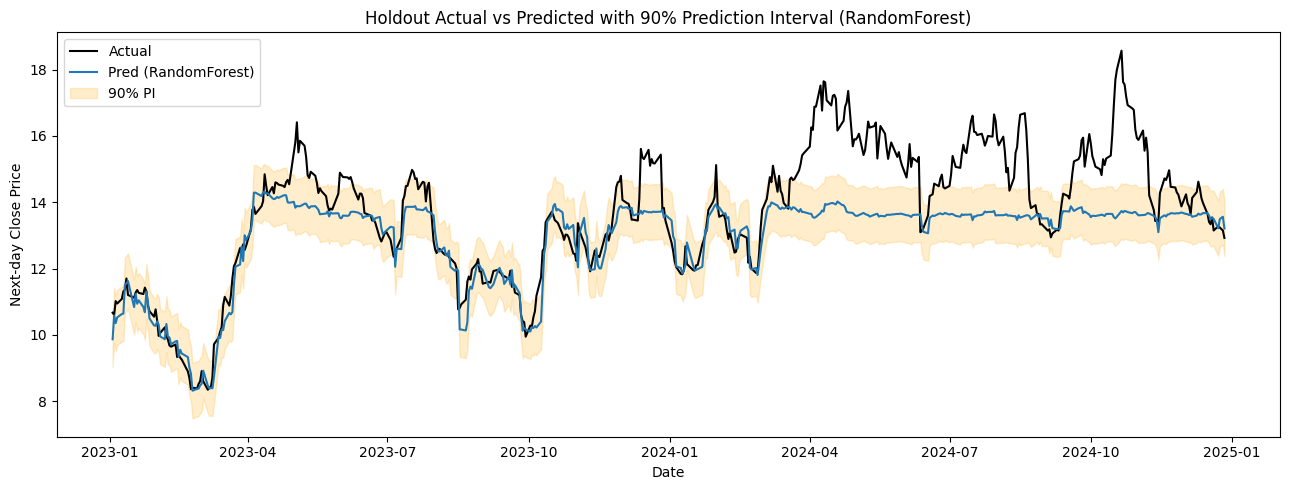

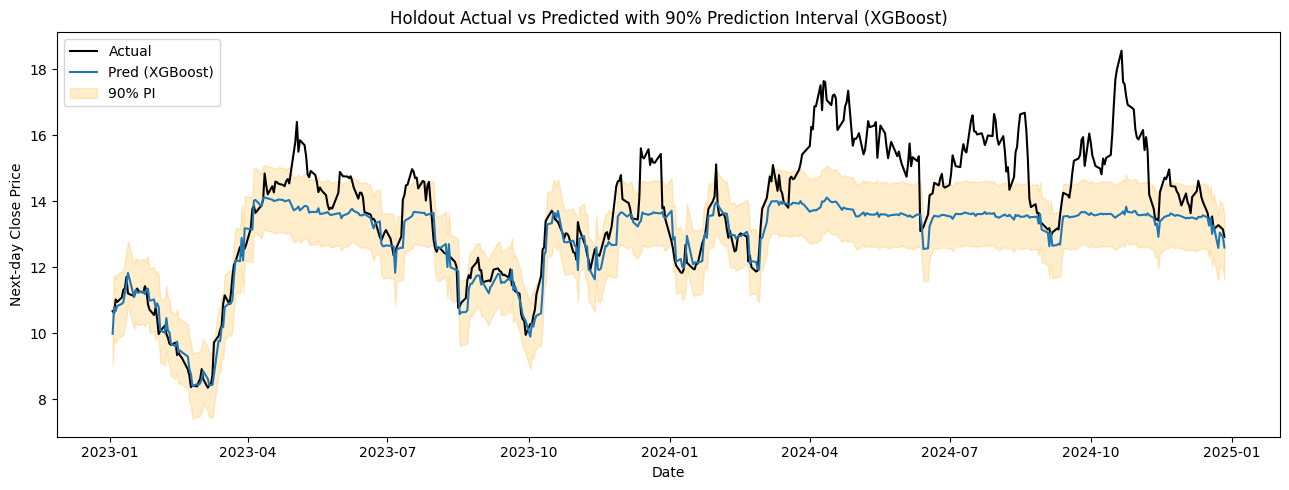

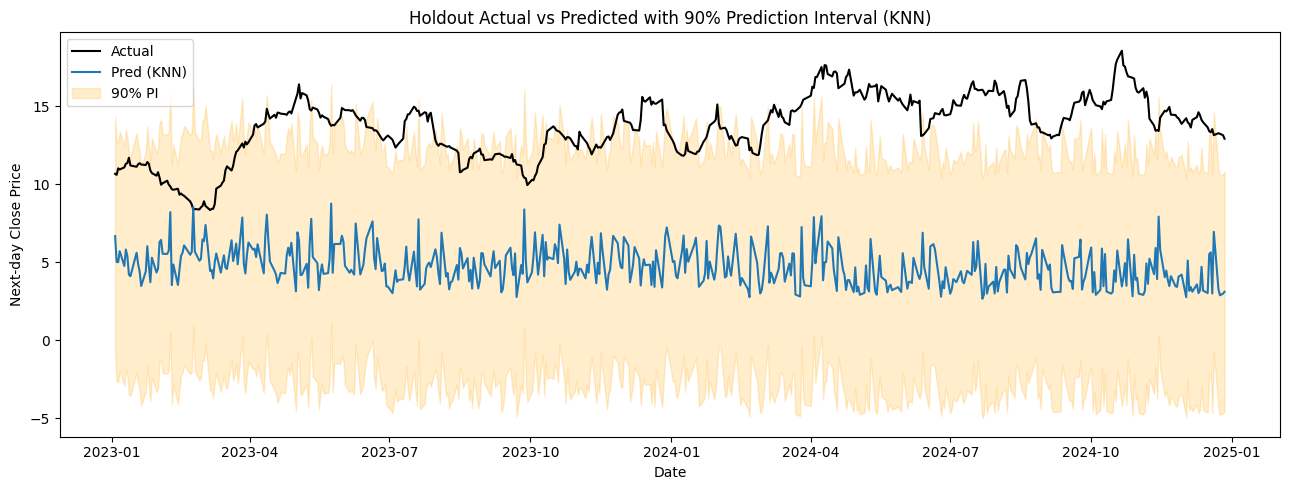

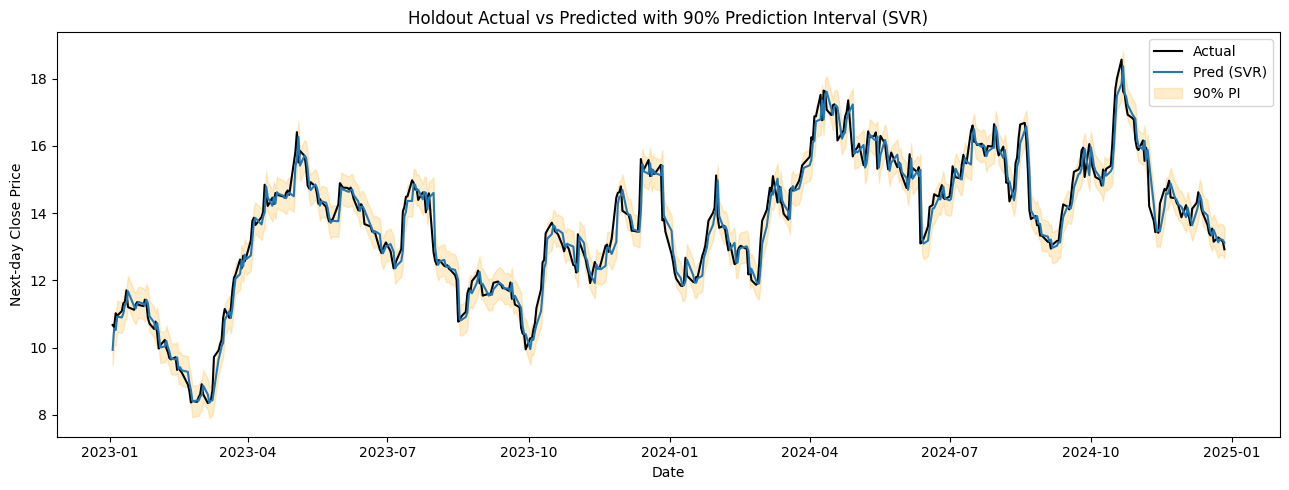

In [ ]:
models_dict = {
    "RandomForest": rf_best,
    "XGBoost": xgb_best,
    "KNN": knn_best,
    "SVR": svr_best
}

for name, model in models_dict.items():
    # --- Split-conformal prediction interval for each model ---
    cal_n = max(20, int(0.2 * len(X_train)))  # 20% calibration set
    X_cal, y_cal = X_train[-cal_n:], y_train[-cal_n:]
    X_tr2, y_tr2 = X_train[:-cal_n], y_train[:-cal_n]

    # Fit on calibration split
    model.fit(X_tr2, y_tr2)
    resid = np.abs(y_cal - model.predict(X_cal))

    alpha = 0.1  # 90% interval
    q = np.quantile(resid, 1 - alpha)

    # Fit on full training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Construct intervals
    lower, upper = y_pred - q, y_pred + q

    # --- Build dataframe for plotting ---
    test_df = pd.DataFrame({
        "Date": pd.to_datetime(dates_test),
        "Actual": y_test,
        "Pred": y_pred,
        "Lower90": lower,
        "Upper90": upper,
    }).sort_values("Date")

    # --- Plot ---
    plt.figure(figsize=(13, 5))
    plt.plot(test_df["Date"], test_df["Actual"], label="Actual", color="black", linewidth=1.5)
    plt.plot(test_df["Date"], test_df["Pred"], label=f"Pred ({name})", linewidth=1.5)
    plt.fill_between(
        test_df["Date"], test_df["Lower90"], test_df["Upper90"],
        color="orange", alpha=0.2, label="90% PI"
    )
    plt.title(f"Holdout Actual vs Predicted with 90% Prediction Interval ({name})")
    plt.xlabel("Date")
    plt.ylabel("Next-day Close Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Residual Diagnostics


🔍 Residual Diagnostics for RandomForest


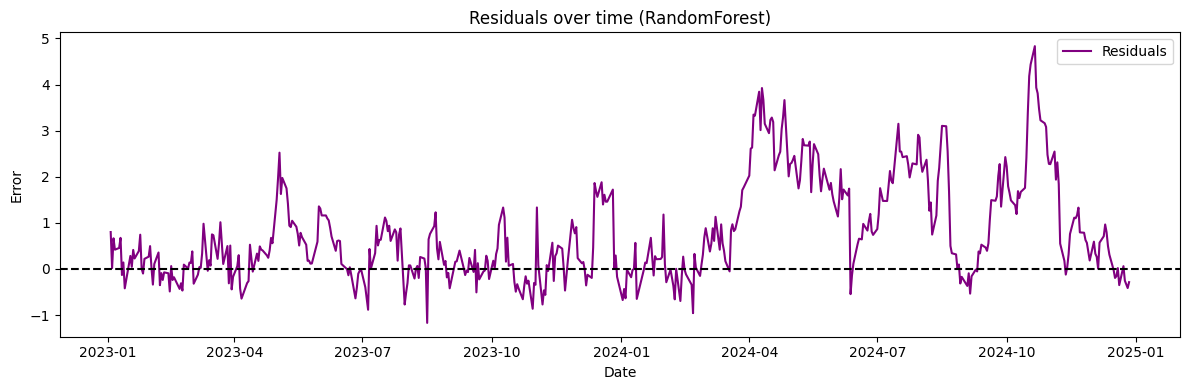

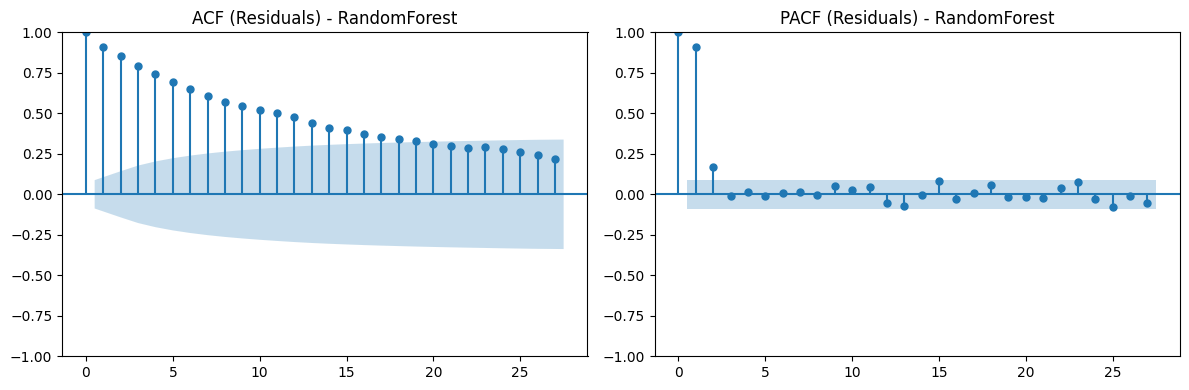

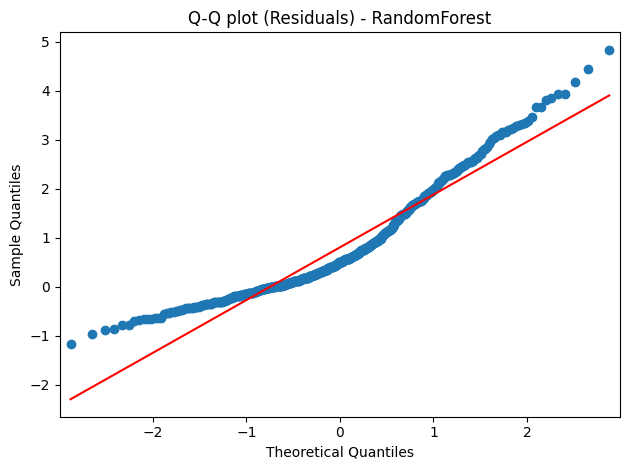


🔍 Residual Diagnostics for XGBoost


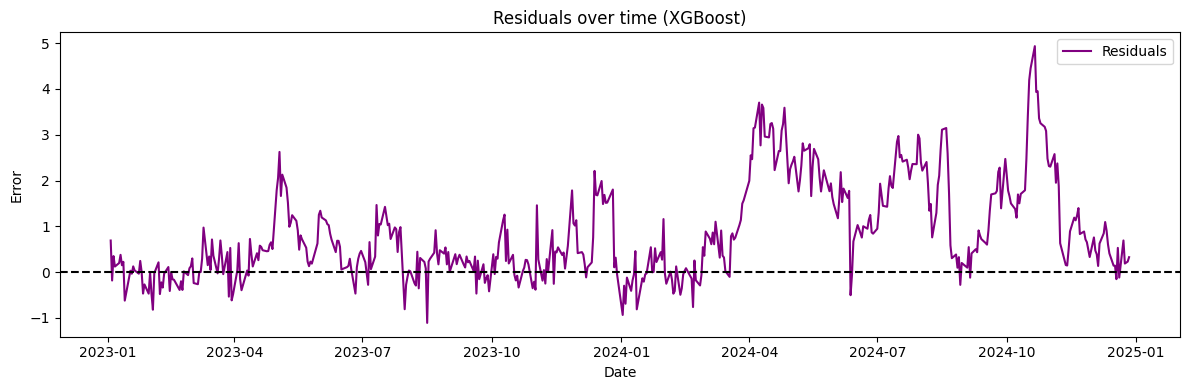

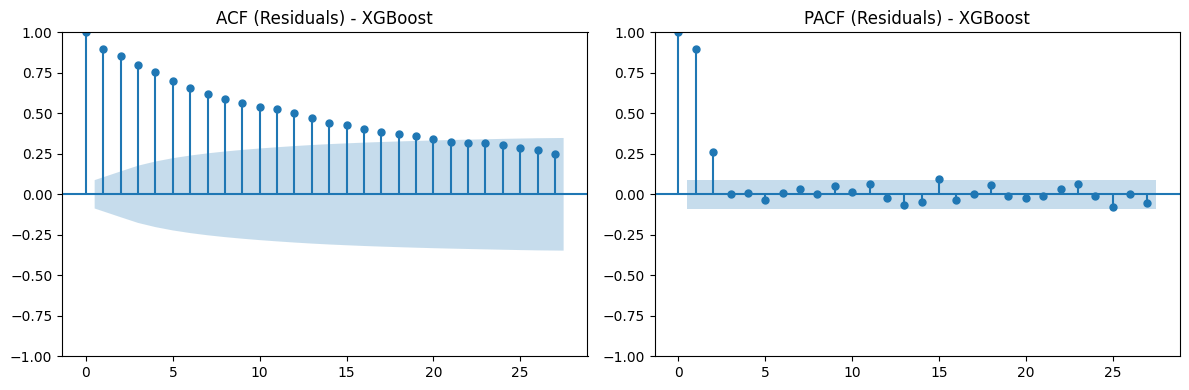

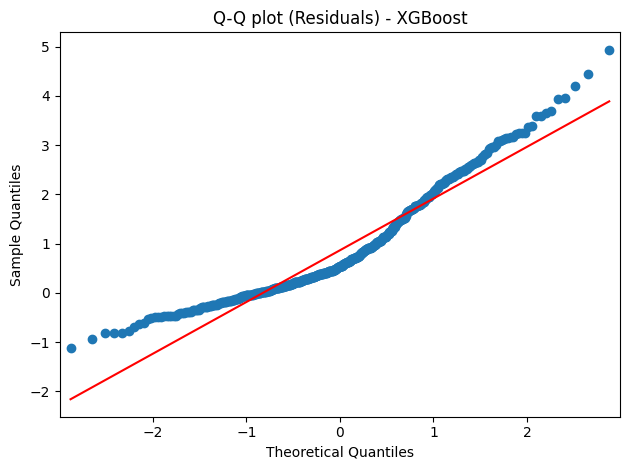


🔍 Residual Diagnostics for KNN


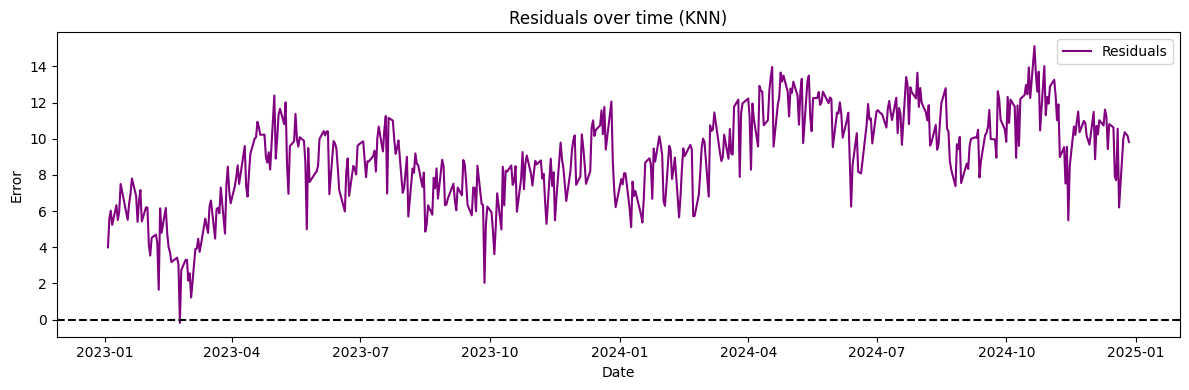

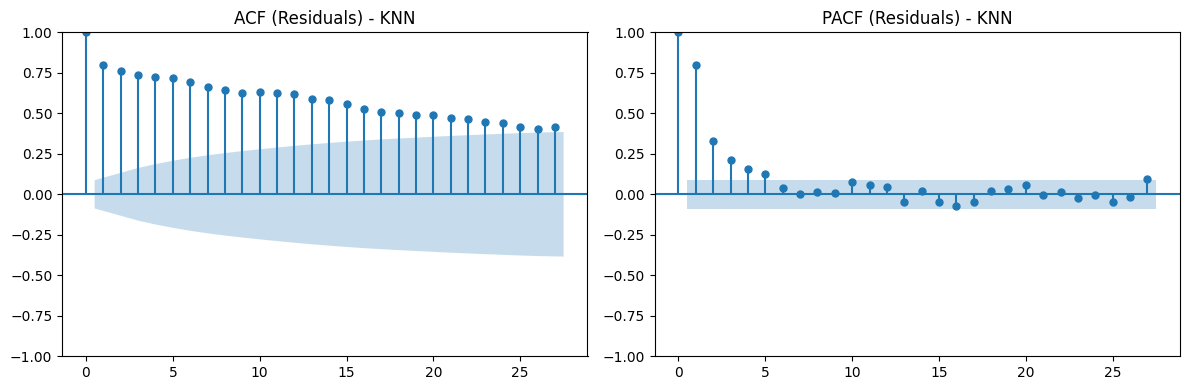

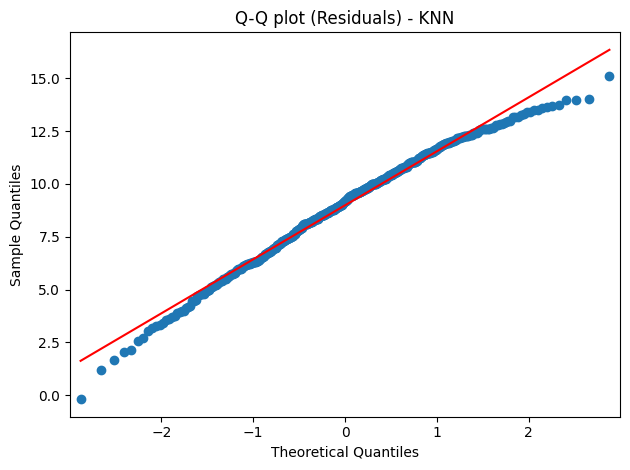


🔍 Residual Diagnostics for SVR


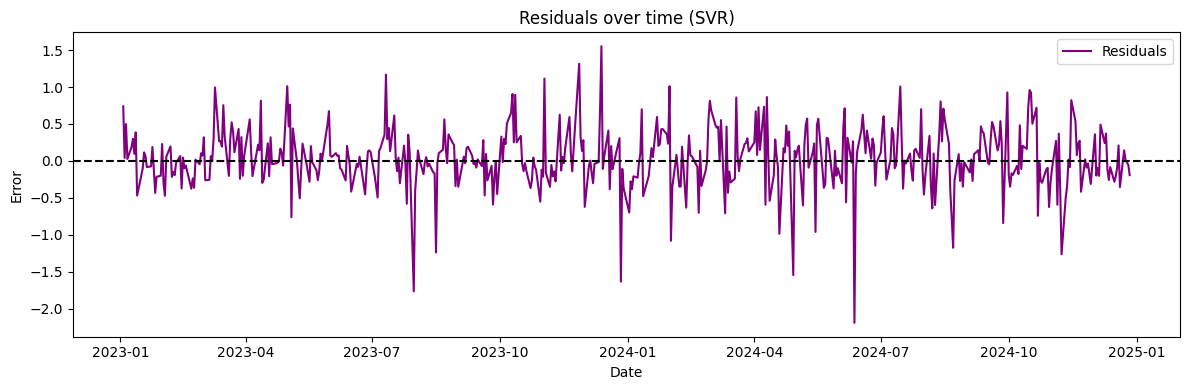

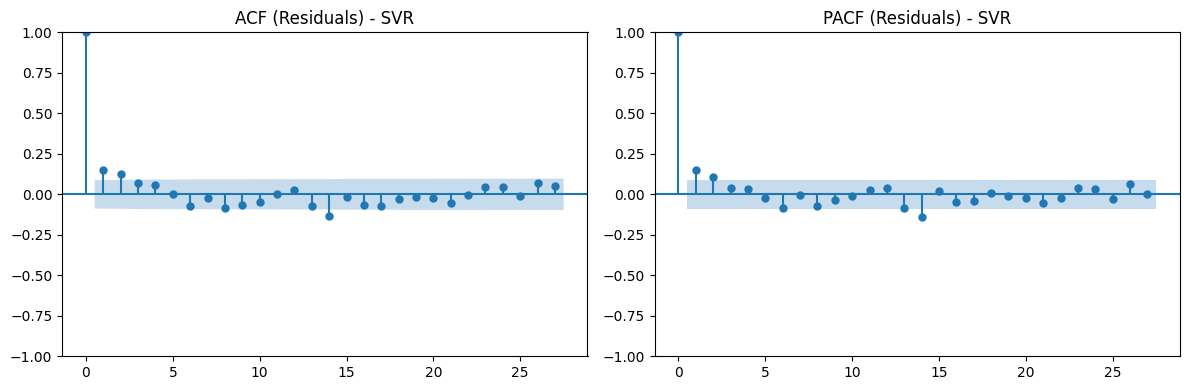

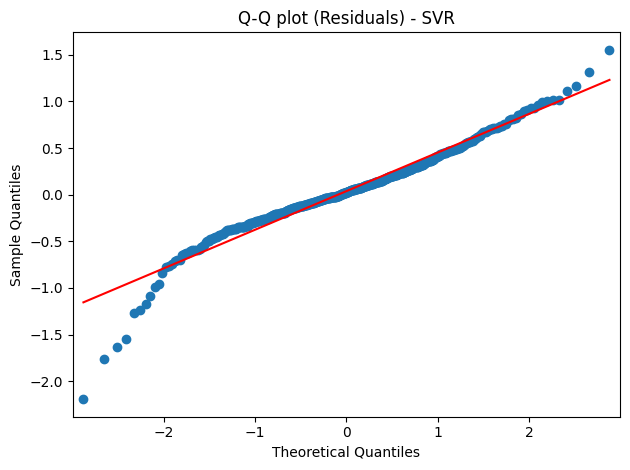

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

models_dict = {
    "RandomForest": rf_best,
    "XGBoost": xgb_best,
    "KNN": knn_best,
    "SVR": svr_best
}

for name, model in models_dict.items():
    print(f"\n🔍 Residual Diagnostics for {name}")

    # Fit model and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    err = y_test - y_pred

    # --- Residuals over time ---
    plt.figure(figsize=(12, 4))
    plt.plot(dates_test, err, color="purple", label="Residuals")
    plt.axhline(0, ls="--", color="black")
    plt.title(f"Residuals over time ({name})")
    plt.xlabel("Date")
    plt.ylabel("Error")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- ACF & PACF of residuals ---
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(121)
    plot_acf(err, ax=ax1, title=f"ACF (Residuals) - {name}")
    ax2 = fig.add_subplot(122)
    plot_pacf(err, ax=ax2, title=f"PACF (Residuals) - {name}", method="ywm")
    plt.tight_layout()
    plt.show()

    # --- Q-Q plot for normality check ---
    sm.qqplot(err, line="s")
    plt.title(f"Q-Q plot (Residuals) - {name}")
    plt.tight_layout()
    plt.show()


# Learning Curve


🔍 Learning Curve for RandomForest


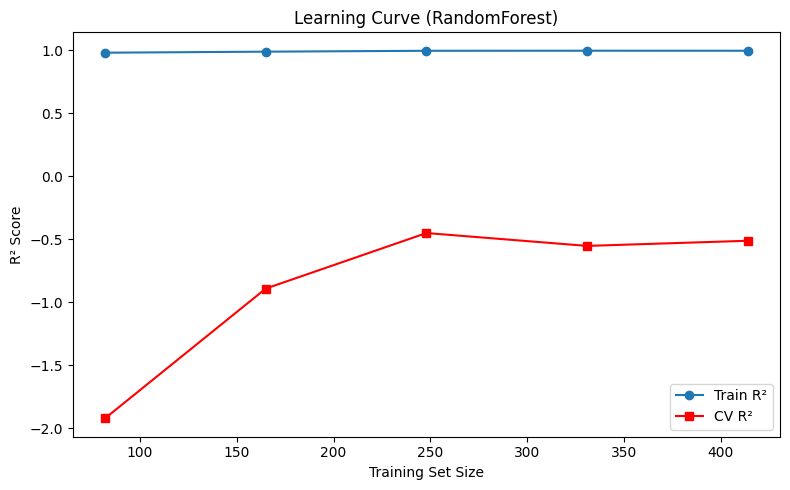


🔍 Learning Curve for XGBoost


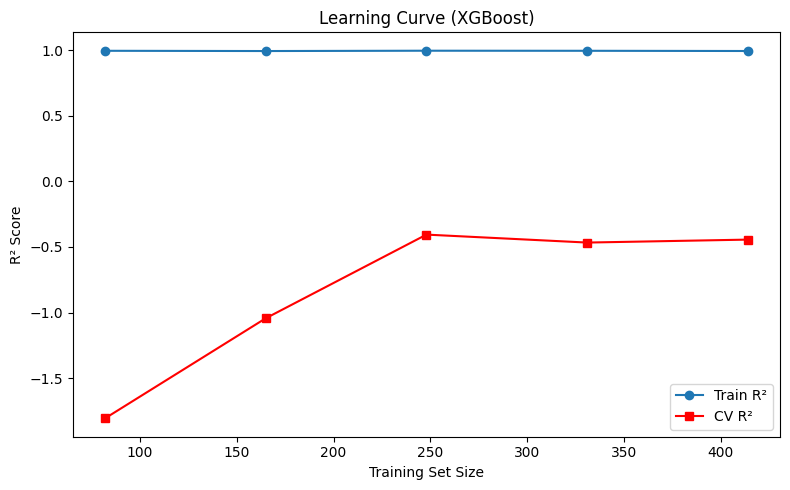


🔍 Learning Curve for KNN


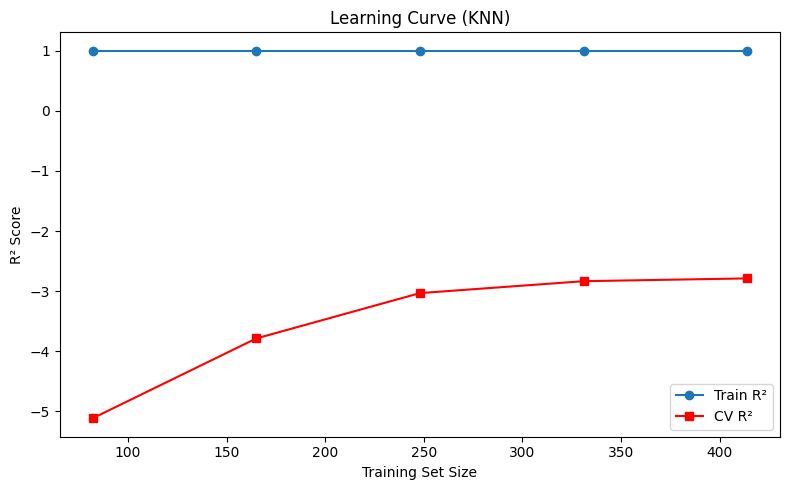


🔍 Learning Curve for SVR


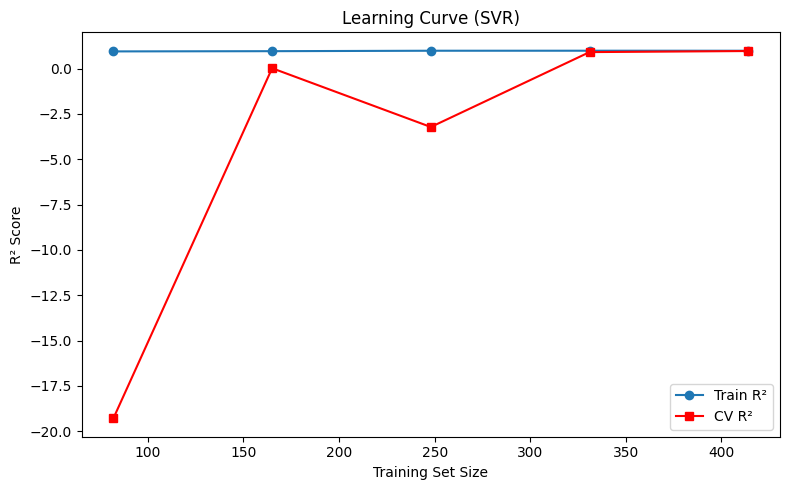

In [ ]:
from sklearn.model_selection import learning_curve, TimeSeriesSplit

models_dict = {
    "RandomForest": rf_best,
    "XGBoost": xgb_best,
    "KNN": knn_best,
    "SVR": svr_best
}

for name, model in models_dict.items():
    print(f"\n🔍 Learning Curve for {name}")

    # Compute learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X_train,
        y=y_train,
        cv=TimeSeriesSplit(n_splits=5),
        scoring="r2",
        train_sizes=np.linspace(0.2, 1.0, 5),
        n_jobs=-1,
        shuffle=False
    )

    # Plot learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Train R²")
    plt.plot(train_sizes, test_scores.mean(axis=1), marker="s", label="CV R²", color="red")
    plt.title(f"Learning Curve ({name})")
    plt.xlabel("Training Set Size")
    plt.ylabel("R² Score")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Permutation Importance


🔍 Permutation Importance for RandomForest


,feature,importance
0,"('Close', 'GFI')",0.654357
1,"('Low', 'GFI')",0.080436
2,"('High', 'GFI')",0.044454
3,"('Open', 'GFI')",0.016326
4,"('MACDsig', '')",0.012759
5,"('Lag1', '')",0.011771
6,"('Volume', 'GFI')",0.002952
7,"('MACD', '')",0.000660
8,"('Day', '')",0.000010
9,"('MACDh', '')",0.000004


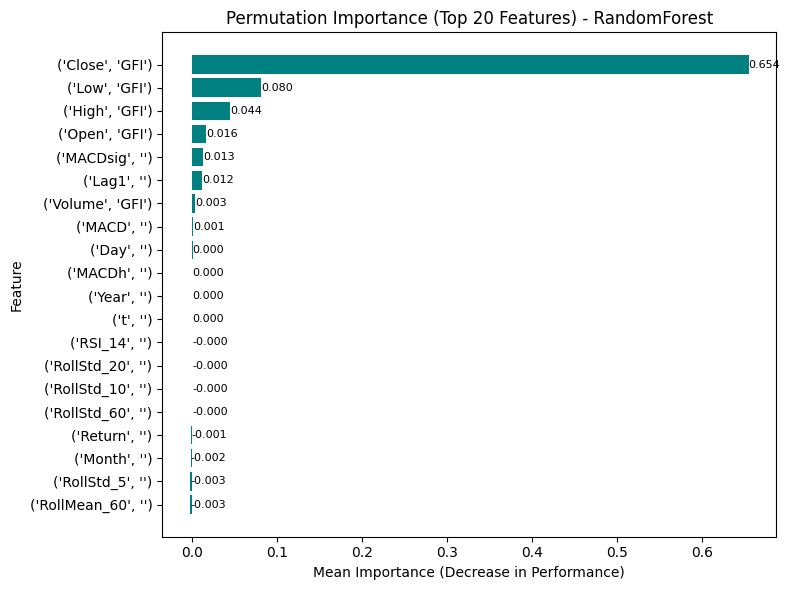


🔍 Permutation Importance for XGBoost


,feature,importance
0,"('Close', 'GFI')",0.451349
1,"('High', 'GFI')",0.109485
2,"('Low', 'GFI')",0.072370
3,"('Open', 'GFI')",0.033067
4,"('Lag1', '')",0.009387
5,"('RollMean_5', '')",0.007654
6,"('MACDsig', '')",0.005340
7,"('MACD', '')",0.003854
8,"('RollMean_20', '')",0.002715
9,"('RollStd_10', '')",0.001943


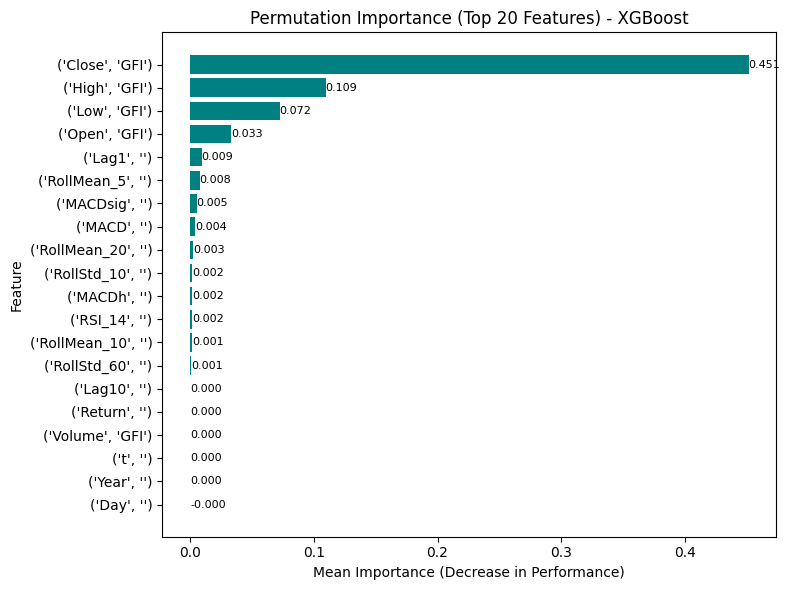


🔍 Permutation Importance for KNN


,feature,importance
0,"('t', '')",0.002420
1,"('Lag10', '')",0.000079
2,"('RollMean_60', '')",0.000068
3,"('RollMean_20', '')",0.000040
4,"('Year', '')",0.000037
5,"('RollStd_10', '')",0.000021
6,"('RollMean_10', '')",0.000017
7,"('RollMean_5', '')",0.000009
8,"('RollStd_20', '')",0.000003
9,"('Return', '')",0.000001


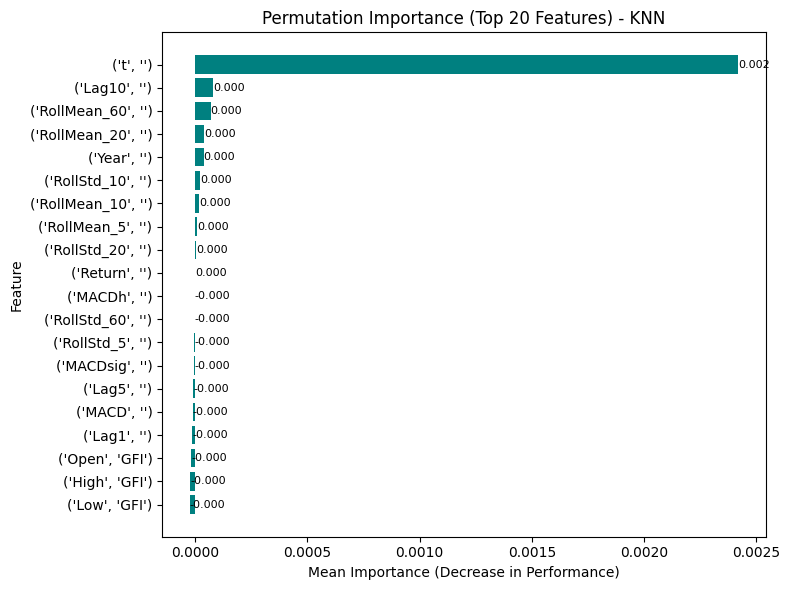


🔍 Permutation Importance for SVR


,feature,importance
0,"('Close', 'GFI')",1.026247e+00
1,"('High', 'GFI')",5.241081e-02
2,"('Open', 'GFI')",1.870384e-02
3,"('Low', 'GFI')",1.231318e-02
4,"('Lag1', '')",5.561183e-03
5,"('RollMean_5', '')",2.696692e-03
6,"('MACDh', '')",1.225762e-03
7,"('Lag5', '')",4.985892e-04
8,"('Return', '')",4.888339e-04
9,"('RollStd_20', '')",9.844346e-05


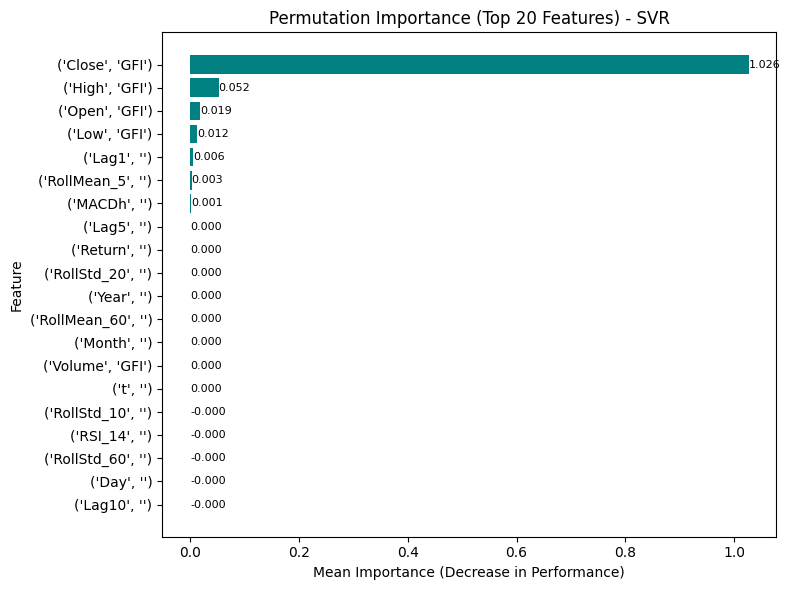

In [ ]:
from sklearn.inspection import permutation_importance

models_dict = {
    "RandomForest": rf_best,
    "XGBoost": xgb_best,
    "KNN": knn_best,
    "SVR": svr_best
}

for name, model in models_dict.items():
    print(f"\n🔍 Permutation Importance for {name}")

    # Compute permutation importance
    perm = permutation_importance(
        estimator=model,
        X=X_test,
        y=y_test,
        n_repeats=10,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    # Build importance DataFrame
    imp = (
        pd.DataFrame({
            "feature": feat_cols,
            "importance": perm.importances_mean
        })
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )

    # Ensure correct dtypes
    imp["feature"] = imp["feature"].astype(str)
    imp["importance"] = imp["importance"].astype(float)

    # Show top 15 features in table
    display(imp.head(15))

    # Plot Top 20 Features
    top_imp = imp.head(20).iloc[::-1]  # reverse order for barh

    plt.figure(figsize=(8, 6))
    plt.barh(top_imp["feature"], top_imp["importance"], color="teal")
    plt.title(f"Permutation Importance (Top 20 Features) - {name}")
    plt.xlabel("Mean Importance (Decrease in Performance)")
    plt.ylabel("Feature")

    # Add value labels
    for i, v in enumerate(top_imp["importance"]):
        plt.text(v, i, f"{v:.3f}", va="center", ha="left", fontsize=8)

    plt.tight_layout()
    plt.show()


# Rolling-Origin Backtest

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def rolling_backtest(model, X, y, splits=5):
    """Perform rolling (walk-forward) backtest with TimeSeriesSplit."""
    tscv = TimeSeriesSplit(n_splits=splits)
    rows = []

    for i, (tr, te) in enumerate(tscv.split(X)):
        mdl = model

        mdl.fit(X.iloc[tr], y.iloc[tr])
        pred = mdl.predict(X.iloc[te])
        met = metrics_dict(y.iloc[te], pred)
        met["Fold"] = i + 1
        rows.append(met)

    return pd.DataFrame(rows)

# --- Run backtests for each model ---
bt_rf  = rolling_backtest(rf_best,  X, pd.Series(y), splits=5).assign(Model="RandomForest")
bt_xgb = rolling_backtest(xgb_best, X, pd.Series(y), splits=5).assign(Model="XGBoost")
bt_knn = rolling_backtest(knn_best, X, pd.Series(y), splits=5).assign(Model="KNN")
bt_svr = rolling_backtest(svr_best, X, pd.Series(y), splits=5).assign(Model="SVR")

bt = pd.concat([bt_rf, bt_xgb, bt_knn, bt_svr], ignore_index=True)

backtest_summary = (
    bt.groupby("Model")[["RMSE", "MAE", "MAPE%", "SMAPE%", "R²"]]
      .mean()
      .sort_values("RMSE")
)

display(backtest_summary)


,RMSE,MAE,MAPE%,SMAPE%,R²
Model,,,,,
SVR,0.251830,0.179982,2.761637,2.754253,0.968171
RandomForest,0.949387,0.598469,7.185382,7.816771,0.672525
XGBoost,0.984470,0.616278,7.371234,8.042672,0.653026
KNN,4.053959,3.663697,41.796934,53.875416,-6.506481
